In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import cv2

### Matrix convolution implementation

In [2]:
def matrix_convolve(input: np.ndarray, kernel: np.ndarray, stride: np.ndarray(shape=(2), dtype=np.int64) = np.ones(2, dtype=np.int64), padding: int = 0, const_val: float = 0, edge_handling: str = "constant") -> np.ndarray:
    """Performs basic convolution on 2d input with 2d kernel.

    Parameters
    ----------
    input : np.ndarray
        The input matrix on which convolution is performed
    kernel : np.ndarray
        The convolution kernel (also matrix); width must equal height
    stride : np.ndarray, optional
        The amount of pixels that kernel moves on each iteration on respective axis (if the next stride would move kernel outside of possible area kernel moves down and start again from the left or stops if it's impossible to move down)
    padding: int, optional
        The width of cells symmetrically added around input with the use of edge_hadling strategy (if padding==0 "crop" strategy is used)
    const_val: float, optional
        Used only if edge_handling==constant
    edge_handling : str, optional
        The way that convolution is handled on edges. Possible values are:
         - "crop" (automatically used if padding==0; can't be passed as argument): Any pixel in the output image which would require values from beyond the edge is skipped.
         - "extend": The nearest border pixels are conceptually extended as far as necessary to provide values for the convolution. Corner pixels are extended in 90° wedges. Other edge pixels are extended in lines
         - "constant": Use const_val value for pixels outside of image.
    Returns
    -------
    np.ndarray
        A result of convolution
    """

    # Check for correct input data
    if len(input.shape) != 2: raise Exception("Error: input should be a 2d matrix")
    if len(kernel.shape) != 2: raise Exception("Error: kernel should be a 2d matrix")
    if stride.shape != (2,): raise Exception("Error: stride should be an array with shape (2,)")
    if np.any(stride < 1): raise Exception("Error: stride values should be an integer greater than or equal 1")
    if padding < 0: raise Exception("Error: padding should be an integer greater than or equal 0")
    if np.min(kernel.shape) <= padding: raise Exception("Error: padding value is too large for your kernel")
    if edge_handling not in ["extend", "constant"]: raise Exception("Error: illegal edge_handling value")
    
    input_copy = np.copy(input)
    
    # Add padding
    if padding > 0:
        if edge_handling == "extend":
            input_copy = np.pad(input_copy, pad_width=((padding,), (padding,)), mode='edge')
        if edge_handling == "constant":
            input_copy = np.pad(input_copy, pad_width=((padding,), (padding,)), constant_values=((const_val,), (const_val,)))
      
    if np.any(kernel.shape > input_copy.shape): raise Exception("Error: kernel can't be bigger than input after padding in any dimension")
    
    # Get dimensions of input and kernel, as well as amount of steps needed
    input_h, input_w = input_copy.shape
    kernel_h, kernel_w = kernel.shape
    delta_h = ceil((input_h - kernel_h + 1) / stride[0])
    delta_w = ceil((input_w - kernel_w + 1) / stride[1])
    # Define convolution result matrix
    conv_res = np.zeros((delta_h, delta_w))
    
    # Perform convolution, first cycle controls vertical kernel movement,
    # second - horizontal movement
    for i in range(delta_h):
        for j in range(delta_w):
            conv_res[i, j] = np.sum(input_copy[i * stride[0]:i * stride[0] + kernel_h, j * stride[1]:j * stride[1] + kernel_w] * kernel)
            
    return conv_res

# Test 1
input = np.arange(16).reshape((4, 4))
kernel = np.ones((2, 2)) / 4
print(matrix_convolve(input, kernel))

# Test 2
input2 = np.arange(25).reshape((5, 5))
print(matrix_convolve(input2, kernel, stride = np.array([2, 2])))

# Test 3
print(matrix_convolve(input, kernel, padding=1, edge_handling="extend"))

# Test 4
print(matrix_convolve(input, kernel, padding=1, edge_handling="constant", const_val=0))

# Test 5
print(matrix_convolve(np.arange(30).reshape((5, 6)), np.arange(6).reshape((3, 2)), stride=np.array([1, 3]), padding=1, edge_handling="extend"))

[[ 2.5  3.5  4.5]
 [ 6.5  7.5  8.5]
 [10.5 11.5 12.5]]
[[ 3.  5.]
 [13. 15.]]
[[ 0.   0.5  1.5  2.5  3. ]
 [ 2.   2.5  3.5  4.5  5. ]
 [ 6.   6.5  7.5  8.5  9. ]
 [10.  10.5 11.5 12.5 13. ]
 [12.  12.5 13.5 14.5 15. ]]
[[ 0.    0.25  0.75  1.25  0.75]
 [ 1.    2.5   3.5   4.5   2.5 ]
 [ 3.    6.5   7.5   8.5   4.5 ]
 [ 5.   10.5  11.5  12.5   6.5 ]
 [ 3.    6.25  6.75  7.25  3.75]]
[[ 54.  93. 129.]
 [138. 177. 213.]
 [228. 267. 303.]
 [318. 357. 393.]
 [354. 393. 429.]]


### Filter application

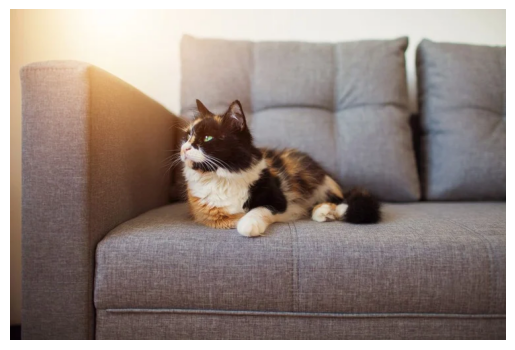

In [3]:
# Read the image in BGR format
img_np = cv2.imread("cat.png")

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

# Convert to PyTorch tensor
img_tensor_HWC = torch.tensor(img_rgb, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
img_tensor_CHW = img_tensor_HWC.permute(2, 0, 1)

# Display the image
plt.imshow(img_tensor_HWC)
plt.axis(False)
plt.show()

#### Gaussian blur

In [4]:
# Function for displaying two images (original and modified)
def compare_output(input, title, cmap="ignore", original = img_tensor_HWC):
    plt.figure(figsize = (15, 5))
    plt.subplot(121)
    plt.imshow(original)
    plt.title("Original image")
    plt.axis(False)
    plt.subplot(122)
    if cmap == "ignore": plt.imshow(input.permute(1, 2, 0))
    else: plt.imshow(input.permute(1, 2, 0), cmap=cmap)
    plt.title(title)
    plt.axis(False)
    plt.show()

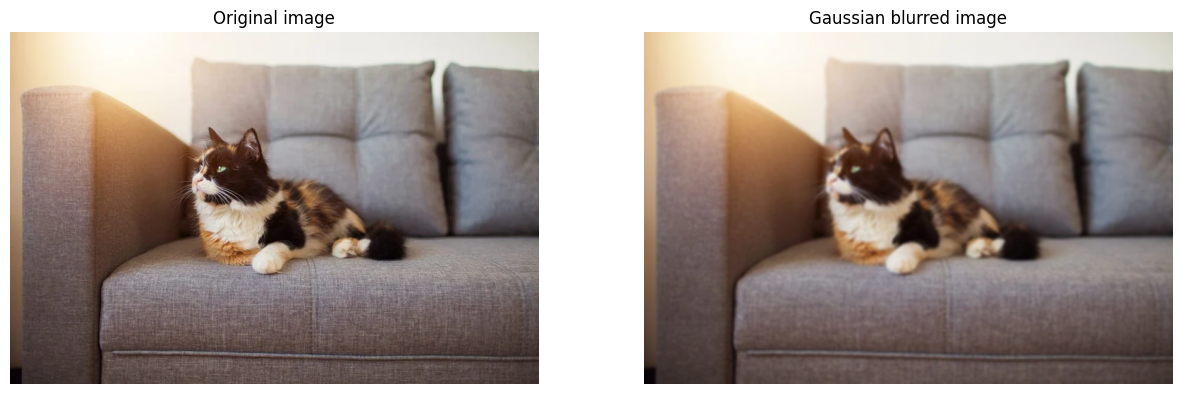

In [5]:
# Perform Gauissian blur
blurrer = torchvision.transforms.GaussianBlur(kernel_size=(5, 5), sigma=5)
blurred_img_tensor_GB = blurrer(img_tensor_CHW)
compare_output(blurred_img_tensor_GB, "Gaussian blurred image")

#### Box filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


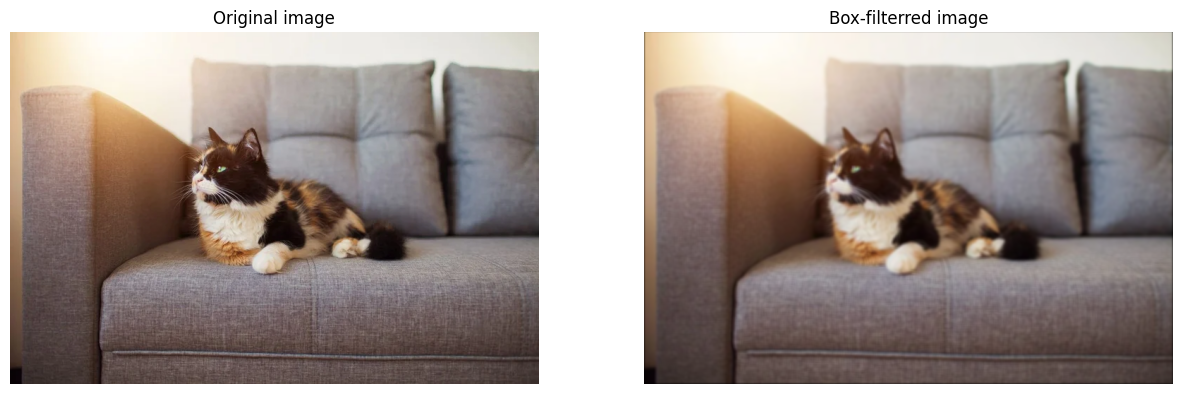

In [6]:
# Create 5x5 box filter with 1/25 values for 3 colour channels
box_filter = torch.ones((3, 1, 5, 5)) / 25
# Apply box-filter
blurred_img_tensor_BF = F.conv2d(img_tensor_CHW, box_filter, padding="same", groups=3)
compare_output(blurred_img_tensor_BF, "Box-filterred image")

#### Unsharp masking

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


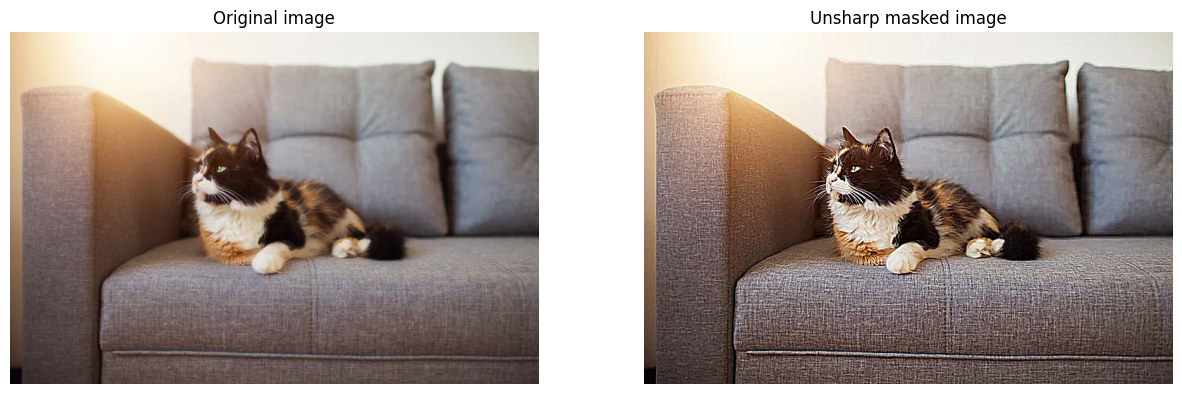

In [7]:
# amount controls the power of unsharp masking
amount = 3
# sharpened = original + (original − blurred) × amount
img_tensor_unsharp_mask = img_tensor_CHW + (img_tensor_CHW - blurred_img_tensor_GB) * amount
compare_output(img_tensor_unsharp_mask, "Unsharp masked image")

#### Sobel operator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


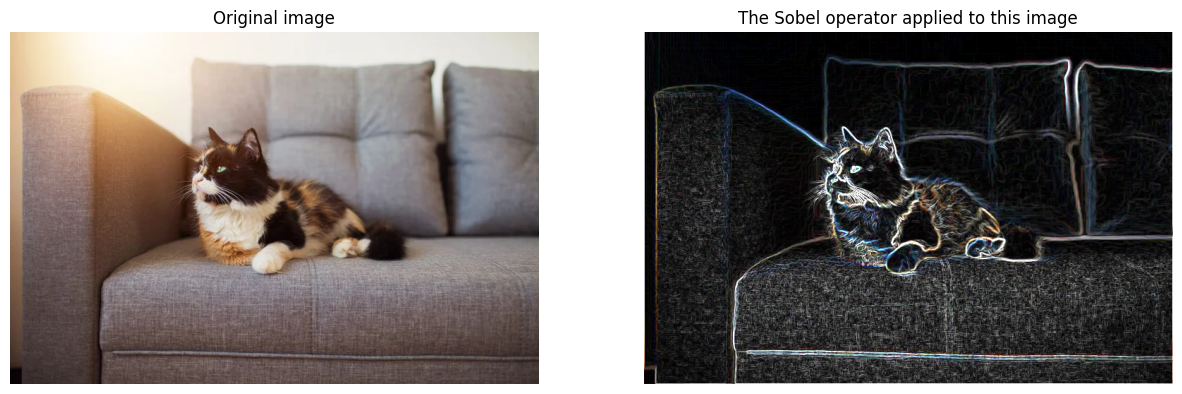

In [8]:
Gx = torch.tensor([[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]]).unsqueeze(0).unsqueeze(1).expand(3, 1, 3, 3)
Gy = torch.tensor([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]).unsqueeze(0).unsqueeze(1).expand(3, 1, 3, 3)
# Perform x-axis and y-axis convolution with Sobel operators
img_tensor_Gx = F.conv2d(img_tensor_CHW, Gx, padding="same", groups=3)
img_tensor_Gy = F.conv2d(img_tensor_CHW, Gy, padding="same", groups=3)

# Calculate gradient magnitude
img_tensor_Sobel_operator = torch.sqrt(img_tensor_Gx ** 2 + img_tensor_Gy ** 2)
compare_output(img_tensor_Sobel_operator, "The Sobel operator applied to this image")

### As we see, this transformation preserves colour (by the way colour identifies edge's angle), let's try different approach to achieve black and white result

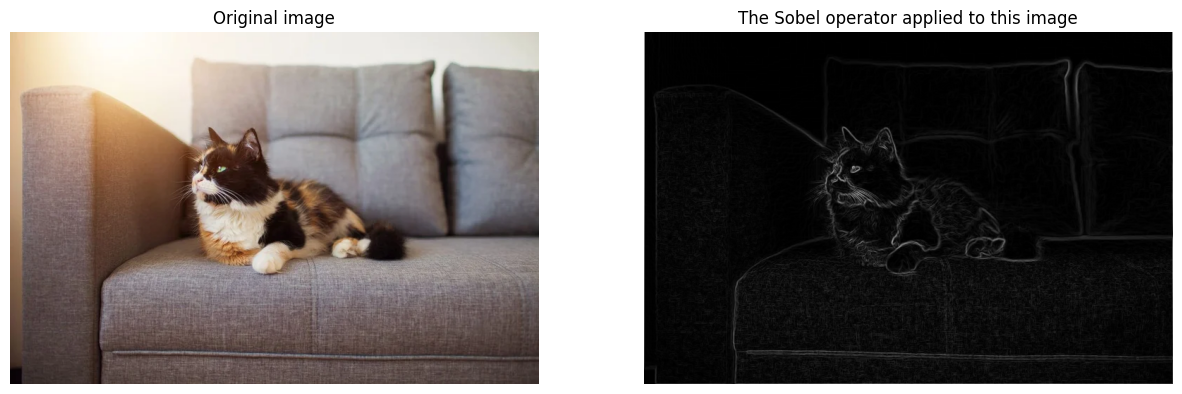

In [9]:
# Convert to grayscale
img_gray_CHW = transforms.functional.rgb_to_grayscale(img_tensor_CHW)

Gx_gray = torch.tensor([[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]]).expand(1, 1, 3, 3)
Gy_gray = torch.tensor([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]).expand(1, 1, 3, 3)

# Perform x-axis and y-axis convolution with Sobel operators
img_tensor_Gx_gray = F.conv2d(img_gray_CHW, Gx_gray, padding="same")
img_tensor_Gy_gray = F.conv2d(img_gray_CHW, Gy_gray, padding="same")

# Calculate gradient magnitude
img_tensor_Sobel_operator_gray = torch.sqrt(img_tensor_Gx_gray ** 2 + img_tensor_Gy_gray ** 2)
compare_output(img_tensor_Sobel_operator_gray, "The Sobel operator applied to this image", cmap="grey")

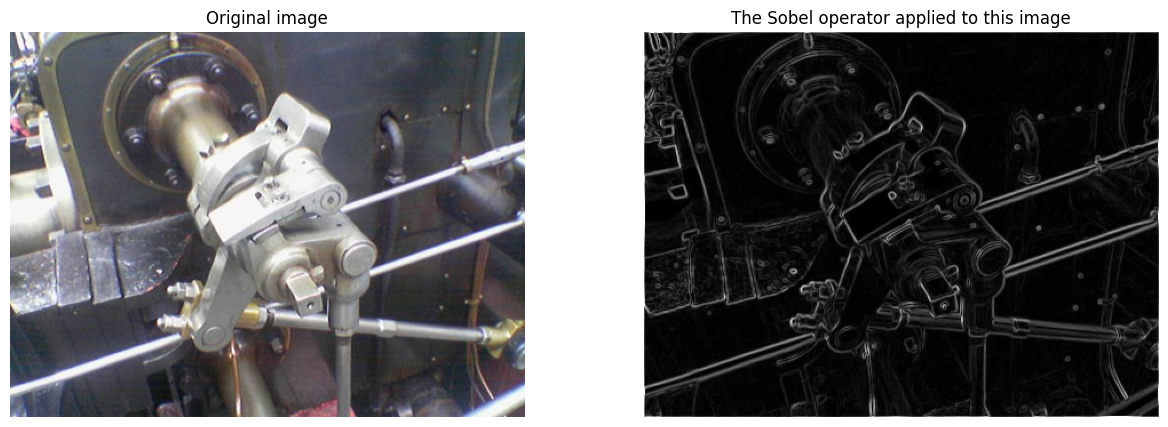

In [10]:
# Test another image with more pronounced edges

# Read the image in BGR format
valve_np = cv2.imread("valve.png")

# Convert BGR to RGB
valve_rgb = cv2.cvtColor(valve_np, cv2.COLOR_BGR2RGB)

# Convert to PyTorch tensor
valve_tensor_HWC = torch.tensor(valve_rgb, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
valve_tensor_CHW = valve_tensor_HWC.permute(2, 0, 1)
# Convert to grayscale
valve_gray_CHW = transforms.functional.rgb_to_grayscale(valve_tensor_CHW)

# Perform x-axis and y-axis convolution with Sobel operators
valve_tensor_Gx_gray = F.conv2d(valve_gray_CHW, Gx_gray, padding="same")
valve_tensor_Gy_gray = F.conv2d(valve_gray_CHW, Gy_gray, padding="same")

# Calculate gradient magnitude
valve_tensor_Sobel_operator_gray = torch.sqrt(valve_tensor_Gx_gray ** 2 + valve_tensor_Gy_gray ** 2)
compare_output(valve_tensor_Sobel_operator_gray, "The Sobel operator applied to this image", cmap="grey", original=valve_tensor_HWC)

### Normalization

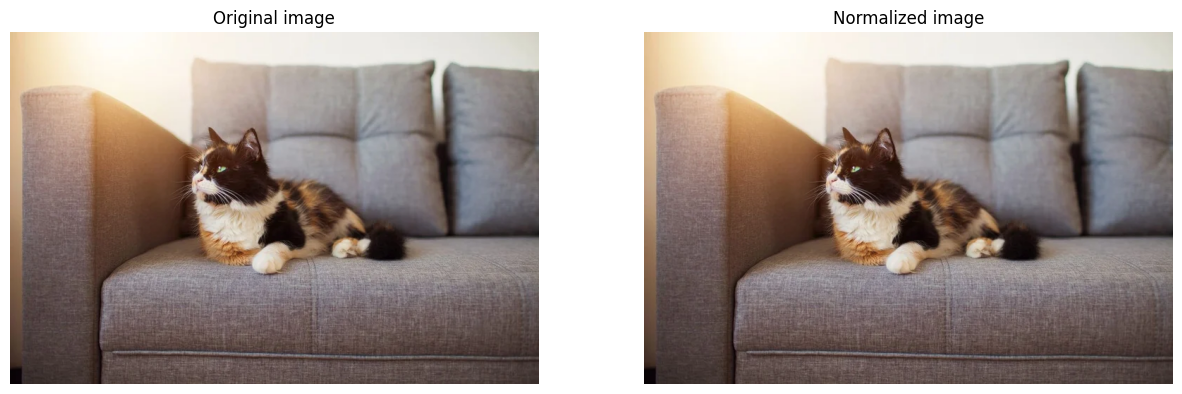

In [11]:
cat_tensor = torch.tensor(img_rgb, dtype=torch.float32)
# Calculate min and max
min, max = cat_tensor.min(), cat_tensor.max()
cat_tensor_norm = (cat_tensor - min) / (max - min)
compare_output(cat_tensor_norm.permute(2, 0, 1), "Normalized image")

### As we see the image is displayed identicaly, to see the difference we need to take a look at tensor values

In [12]:
print(cat_tensor)

tensor([[[224., 193., 144.],
         [224., 193., 144.],
         [224., 193., 144.],
         ...,
         [208., 207., 196.],
         [208., 207., 196.],
         [208., 207., 196.]],

        [[224., 193., 144.],
         [224., 193., 144.],
         [224., 193., 144.],
         ...,
         [208., 207., 196.],
         [208., 207., 196.],
         [208., 207., 196.]],

        [[224., 193., 144.],
         [224., 193., 144.],
         [224., 193., 144.],
         ...,
         [209., 208., 197.],
         [208., 207., 196.],
         [208., 207., 196.]],

        ...,

        [[  8.,   3.,   5.],
         [  8.,   3.,   5.],
         [  8.,   3.,   5.],
         ...,
         [ 57.,  46.,  43.],
         [ 58.,  47.,  44.],
         [ 58.,  47.,  44.]],

        [[  8.,   3.,   5.],
         [  8.,   3.,   5.],
         [  8.,   3.,   5.],
         ...,
         [ 58.,  47.,  44.],
         [ 59.,  48.,  45.],
         [ 59.,  48.,  45.]],

        [[  8.,   3.,   5.],
       

In [13]:
print(cat_tensor_norm)

tensor([[[0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         ...,
         [0.8157, 0.8118, 0.7686],
         [0.8157, 0.8118, 0.7686],
         [0.8157, 0.8118, 0.7686]],

        [[0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         ...,
         [0.8157, 0.8118, 0.7686],
         [0.8157, 0.8118, 0.7686],
         [0.8157, 0.8118, 0.7686]],

        [[0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         [0.8784, 0.7569, 0.5647],
         ...,
         [0.8196, 0.8157, 0.7725],
         [0.8157, 0.8118, 0.7686],
         [0.8157, 0.8118, 0.7686]],

        ...,

        [[0.0314, 0.0118, 0.0196],
         [0.0314, 0.0118, 0.0196],
         [0.0314, 0.0118, 0.0196],
         ...,
         [0.2235, 0.1804, 0.1686],
         [0.2275, 0.1843, 0.1725],
         [0.2275, 0.1843, 0.1725]],

        [[0.0314, 0.0118, 0.0196],
         [0.0314, 0.0118, 0.0196],
         [0.

### Standartization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


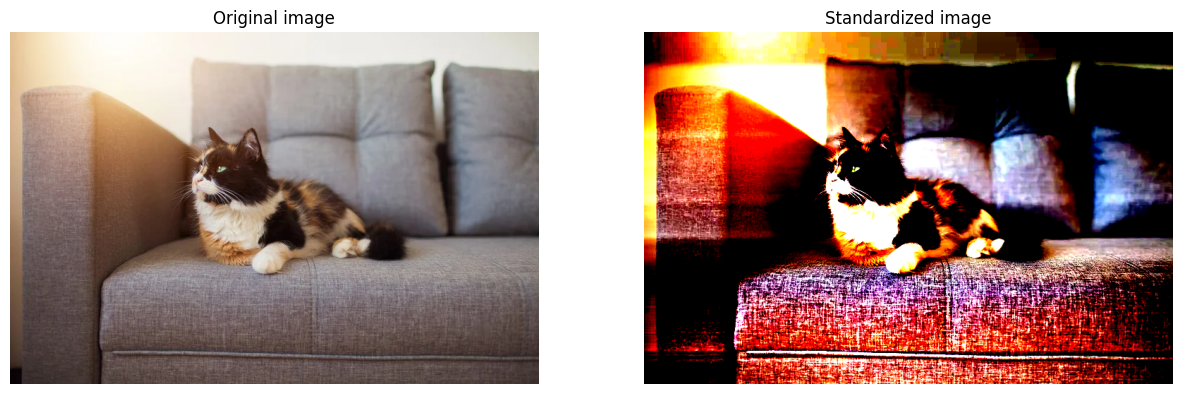

In [14]:
# calculate mean and std
mean, std = cat_tensor.mean([1,2]), cat_tensor.std([1,2])
stdizer = transforms.Normalize(mean, std)
cat_tensor_std = stdizer(cat_tensor)
compare_output(cat_tensor_std.permute(2, 0, 1), "Standardized image")

In [15]:
# Calculate mean and std of standardized image
mean_new, std_new = cat_tensor_std.mean([1,2]), cat_tensor_std.std([1,2])
 
print("Mean and Std of normalized image:")
print("Mean of the image:", mean_new)

Mean and Std of normalized image:
Mean of the image: tensor([ 9.4096e-08,  9.4096e-08,  3.8136e-07,  3.8136e-07,  6.8241e-08,
         6.8241e-08, -2.5696e-07, -2.6947e-07, -1.7325e-07, -1.7177e-07,
        -2.9023e-07,  3.2955e-08, -3.7935e-08,  2.8854e-07,  4.7567e-07,
        -3.2022e-07,  8.0109e-08, -4.4526e-07,  3.1122e-07, -3.8136e-07,
         2.7572e-07, -4.7482e-07, -3.4703e-07,  4.4420e-07,  3.1090e-07,
        -2.1733e-07,  3.0867e-07, -7.7989e-08, -2.4245e-07, -1.2281e-07,
        -2.5929e-07,  2.1691e-07,  2.3948e-07, -3.4173e-07, -4.3848e-07,
         3.3559e-07, -2.1860e-07,  3.0581e-07,  4.1887e-07, -4.7620e-07,
        -1.3945e-07, -3.7331e-07, -8.4135e-08, -9.1765e-08,  1.3680e-07,
        -9.6427e-09,  2.0260e-07,  9.7699e-08, -2.5039e-07, -8.9963e-08,
         1.6816e-07, -2.2888e-08, -1.4252e-07, -1.1879e-07,  5.8810e-08,
        -8.1115e-08,  4.1167e-08,  1.3108e-07,  1.7659e-07, -5.2028e-08,
        -3.3644e-08, -1.0580e-07,  1.2928e-08, -1.0120e-08,  1.4612e-07

In [16]:
print("Std of the image:", std_new)

Std of the image: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000